This notebook implements the Lattice Boltzmann Method (LBM) for fluid flow passing a cylindrical obstacle.

# LBM Cookbook

1. Define some constants such as the Reynolds number (Re), inital horizontal inflow velocity ($u_0$) and number of simulation time steps. 

2. Define the size fo the domain and use that to define the central indices of the cylinder. Use the size of the doamin to obtain a mesh and create a boolean mask that models the cylindrical obstacle.

3. Define the relative directions of the discrete lattice velocities (DLV). Note the order of the coordinates, it should reflect the D2Q9 diagram in the report.

4. Based on the DLV, define two 1D arrays with 9 elements each with indices that correspond to the discrete lattice velocities and the corresponding reflected version. Note the order of the indices, also the center lattice should not be reflected. The purporse is to handle how the local particle should be updated after collision.

5. Define the lattice weights as a 1D array, the numerical values should follow the ones defined in the report. Note that the order must be consistent with the array in step 2.

6. Define a set of 1D arrays with three components that contains the indices for the velocity components right, up, left, down, pure horizontal, and pure vertical. These indices will then be used to update the previous velocities in the specified flow direction. The arrays should follow some specific arrangements according to the D2Q9 scheme. 

7. Use the expression for Reynolds number and the predefined numerical values for Re, L and u0 to determine the the dynamic viscosity $\mu$. 

8. Compute the unitless relaxation time using the formula from the report by setting $\rho = \Delta t = 1$.

9. Initialize the horizontal flow velocity to $u_0$ with no vertical component.

10. Use the DLV and perform a matrix-matrix product with the lattice configuration matrix and obtain an array where each coordinate have the information of the 9 lattice information i.e. the dimension is (Nx, Ny, 9). The result should then be divided by the mass density so we obtain the macrooscopic velocity field (MVF) with dimension (Nx, Ny, 2).

11. Define a function that takes the (Nx, Ny, 9) matrix and returns the macroscopic density by summing the lattice velocity contributions from the last axis. 

12. Define a function that takes the DLV and MVF as input and computes the equilibrium particle distribution. This is done by computing the intermediate results: projected velocities $\mathbf{u}\cdot\mathbf{c}_i$ then the L2-norm squared scalar field 
$||\mathbf{u}||_2^2$. Remember to also to consider the lattice weights and the macroscopic density. Also, be careful of the broadcasting dimension. The result should be an array with dimension (Nx, Ny, 9).

13. Initialize the system by computing the equilibrium particle density. This is done by passing in the homogeneous horizontal velocity field and the homogeneous maroscopic density to the function defined in 12. With the proper initialization, it is possible to iteratively update the system with the update function.

14. Define the update function. Do this by first computing the outflow boundary condition using the homogeneous Neumann boundary condition described in the report. 

15. Compute the macroscopic density using the predefined function and use it to compute the macroscopic velocity.

16. Compute the inflow boundary condition with the homogeneous Dirichlets boundary condition. This can be done by setting the updating the values at the coordinates x=0, all y except from the corners, and all the components of the vector field.

17. Handle the density at the inflow, this can be done by using: 
\begin{equation}
    \rho = \frac{c}{c - u_x}\left[
    f_0 + f_2 + f_4 + 2(f_3 + f_6 + f_7)
    \right]
\end{equation}
with the unitless velocity $c=1$.

18. Compute the equilibrium velocity distribution.

19. Use the computed equilibrium velocity to define the discrete velocity distribution of the inflow. 

20. Compute the collision operator 
\begin{equation}
    \Omega_i(\mathbf{x}, t) = - \frac{1}{\tau} [f_i(\mathbf{x}, t) - f_i^{eq}(\mathbf{x}, t)]
\end{equation}

21. Compute the post collision discrete velocities using
\begin{equation}
  f^{post\, collision}_i(\mathbf{x}, t) = f^{pre\, collision}_i(\mathbf{x}, t) + \Omega_i(\mathbf{x}, t)
\end{equation}

22. Handle the bounce back boundary condition when the particles interacts with the cylinder. Do it by iterating through the lattice indices and the opposite indices.

23. Perform the streaming step.

24. Iteratively calling the update function to obtain the time evolution of the system. 

In [26]:
#!pip install cmasher -q
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm
import numpy as np 
from numba import njit
from matplotlib.animation import *

plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["figure.dpi"] = 150

## Initialization

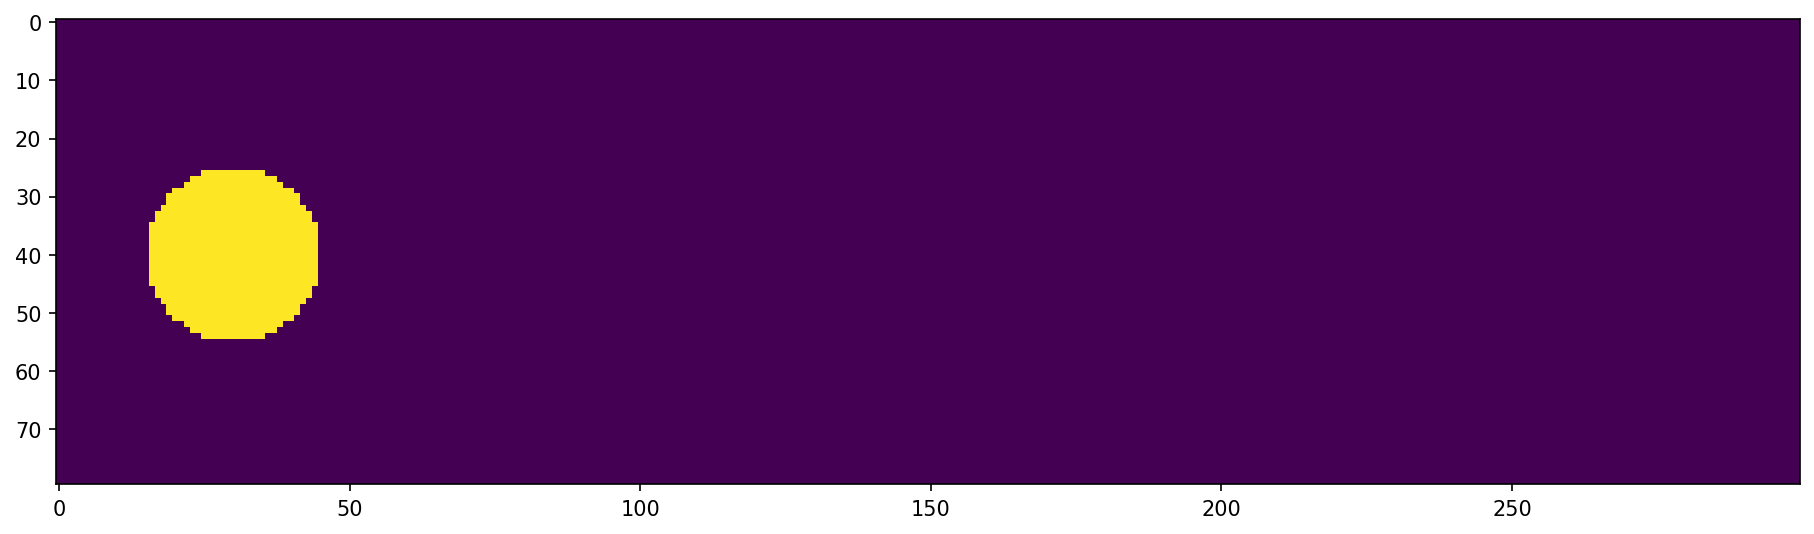

In [34]:
## Unitless physical constants

Re = 80 # Reynold's number
mass_density = 1 # Unitless mass density
inflow_speed = 1 # Initial horizontal inflow, this is assumed to be constant throughout the simulation
dt = 1 # Change in time
simulation_time_steps = 10000 # Total number of steps of the simulation
record_steps = 100 # Record every 100 simulation steps 
Nx, Ny = (300, 80) # Size of the domain
R = Nx // 20 # Radius of the cylinder, this value will be used as the characteristic length
mu = mass_density * inflow_speed * R / Re # Uniteless dynamic viscousity


# The D2Q9 lattice configuration
"""
 6  2  5
  \ | /
3 - 0 - 1 
  / | \
 7  4  8
"""

lattice_config = np.array([
    [ 0,  0],
    [ 1,  0],
    [ 0,  1],
    [-1,  0],
    [ 0, -1],
    [ 1,  1],
    [-1,  1],
    [-1, -1],
    [ 1, -1],
], dtype=float)

lattice_indices = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=float)
reflected_lattice_indices = np.array([0, 3, 4, 1, 2, 7, 8, 5, 6], dtype=float)
lattice_weights = np.array([
    4/9, # center
    1/9, 1/9, 1/9, 1/9, # sides
    1/36, 1/36, 1/36, 1/36, # diagonals
])

# These arrays will determine the flow directions
east_indices = np.array([5, 1, 8], dtype=float)
north_indices = np.array([6, 2, 5], dtype=float)
west_indices = np.array([7, 3, 6], dtype=float)
south_indices = np.array([7, 4, 8], dtype=float)
vertical_indices = np.array([2, 0, 4], dtype=float)
horizontal_indices = np.array([3, 0, 1], dtype=float)


center_of_mass = (Nx//10, Ny//2)
x, y = np.arange(Nx), np.arange(Ny)
X, Y = np.meshgrid(x, y)
# This is a boolean array with True when its considered to be an obstacle and False when it is fluid
cylinder = np.sqrt((X - center_of_mass[0])**2 + (Y - center_of_mass[1])**2) < R

# Initializing the velocity field such that 
# there is a constant horizontal flow form left to right 
u_field = np.zeros([Nx, Ny, 2]) 
u_field[..., 0] = inflow_speed


plt.imshow(cylinder)
plt.show()

In [46]:
def f(lattice_config, u_field): # (Nx, Ny, 2) x (9, 2) -> (Nx, Ny, 9)
    return u_field @ lattice_config.T

def rho(lattice_matrix): # (Nx, Ny, 9) -> (Nx, Ny, 1)
    return lattice_matrix.sum(-1, keepdims=True)


def u(lattice_matrix, lattice_config): # (Nx, Ny, 9) x (9, 2) -> (Nx, Ny, 2)
    return np.einsum("XYQ, Qd -> XYd", lattice_matrix, lattice_config) / rho(lattice_matrix)


lattice_matrix = f(lattice_config, u_field)
#u(lattice_matrix, lattice_config)
rho(lattice_matrix)

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])